# Compare Models

This notebook compares various GFW models based on the `measure_speed` and `measure_course` with each other
and with the models from Dalhousie University.  Note that the distance-to-shore cutoff was disabled in the
Dalhousie models, so none of the models compared here are using distance-to-shore as a feature.

In [11]:
from __future__ import print_function, division
%matplotlib inline
import sys
sys.path.append('..')
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML, Markdown

import vessel_scoring.models
import vessel_scoring.evaluate_model

In [12]:
data = vessel_scoring.models.load_data('../datasets')

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all


Training Logistic (MW & daylight & speed)...
Training Logistic (MW & daylight)...
Training Random Forest (MW & daylight)...
Training Logistic (SW)...
Training Logistic (MW)...
Training Random Forest...
Training Random Forest (MW & daylight & speed)...


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.75|0.25|0.37|
|Logistic (MW & daylight)|0.72|0.23|0.35|
|Logistic (MW)|0.68|0.21|0.33|
|Logistic (SW)|0.50|0.14|0.22|
|Random Forest|0.30|0.16|0.21|
|Random Forest (MW & daylight & speed)|0.72|0.32|0.44|
|Random Forest (MW & daylight)|0.65|0.27|0.38|

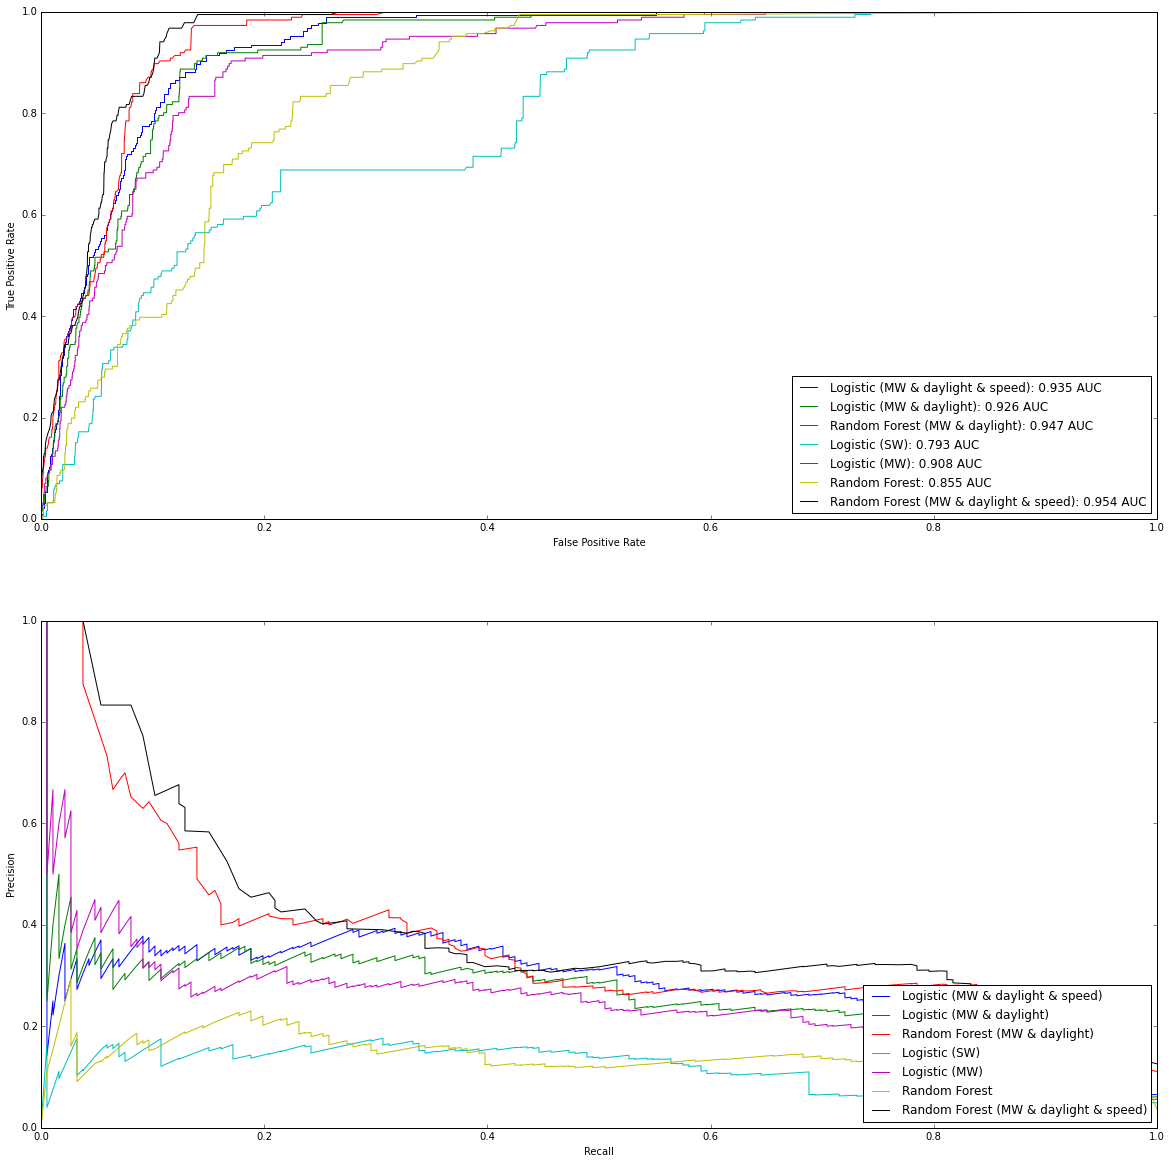

Training Logistic (MW & daylight & speed)...
Training Logistic (MW & daylight)...
Training Random Forest (MW & daylight)...
Training Logistic (SW)...
Training Logistic (MW)...
Training Random Forest...
Training Random Forest (MW & daylight & speed)...


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.89|0.95|0.92|
|Logistic (MW & daylight)|0.89|0.95|0.92|
|Logistic (MW)|0.89|0.95|0.92|
|Logistic (SW)|0.79|0.94|0.86|
|Random Forest|0.91|0.92|0.92|
|Random Forest (MW & daylight & speed)|0.92|0.94|0.93|
|Random Forest (MW & daylight)|0.92|0.94|0.93|

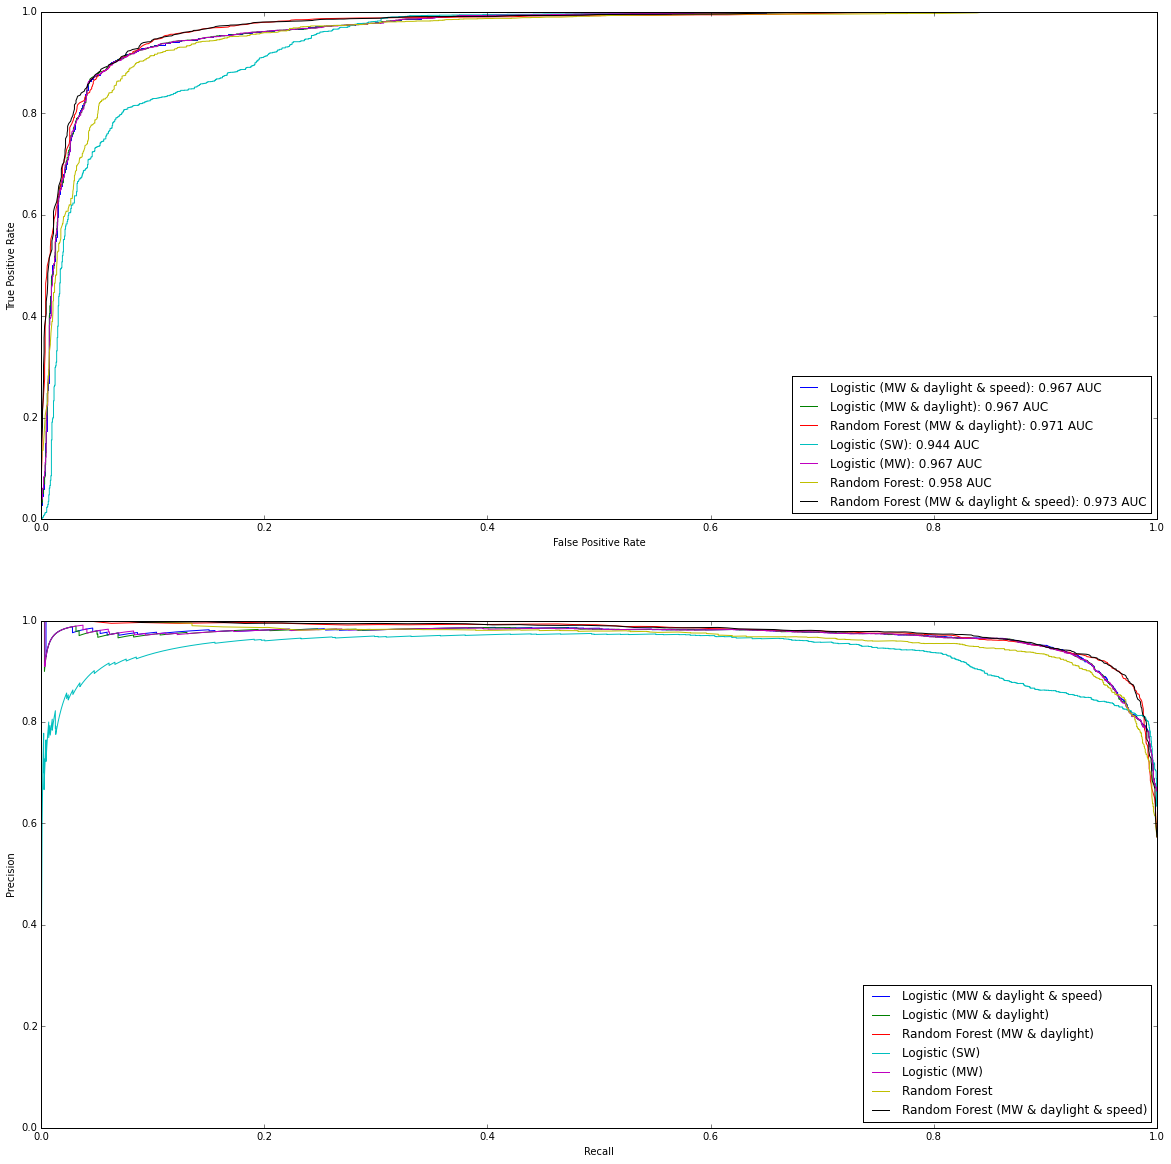

Training Logistic (MW & daylight & speed)...
Training Logistic (MW & daylight)...
Training Random Forest (MW & daylight)...
Training Logistic (SW)...
Training Logistic (MW)...
Training Random Forest...
Training Random Forest (MW & daylight & speed)...


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Logistic (MW & daylight & speed)|0.90|0.97|0.94|
|Logistic (MW & daylight)|0.91|0.97|0.94|
|Logistic (MW)|0.91|0.97|0.94|
|Logistic (SW)|0.62|0.95|0.75|
|Random Forest|0.90|0.96|0.93|
|Random Forest (MW & daylight & speed)|0.96|0.97|0.96|
|Random Forest (MW & daylight)|0.95|0.97|0.96|

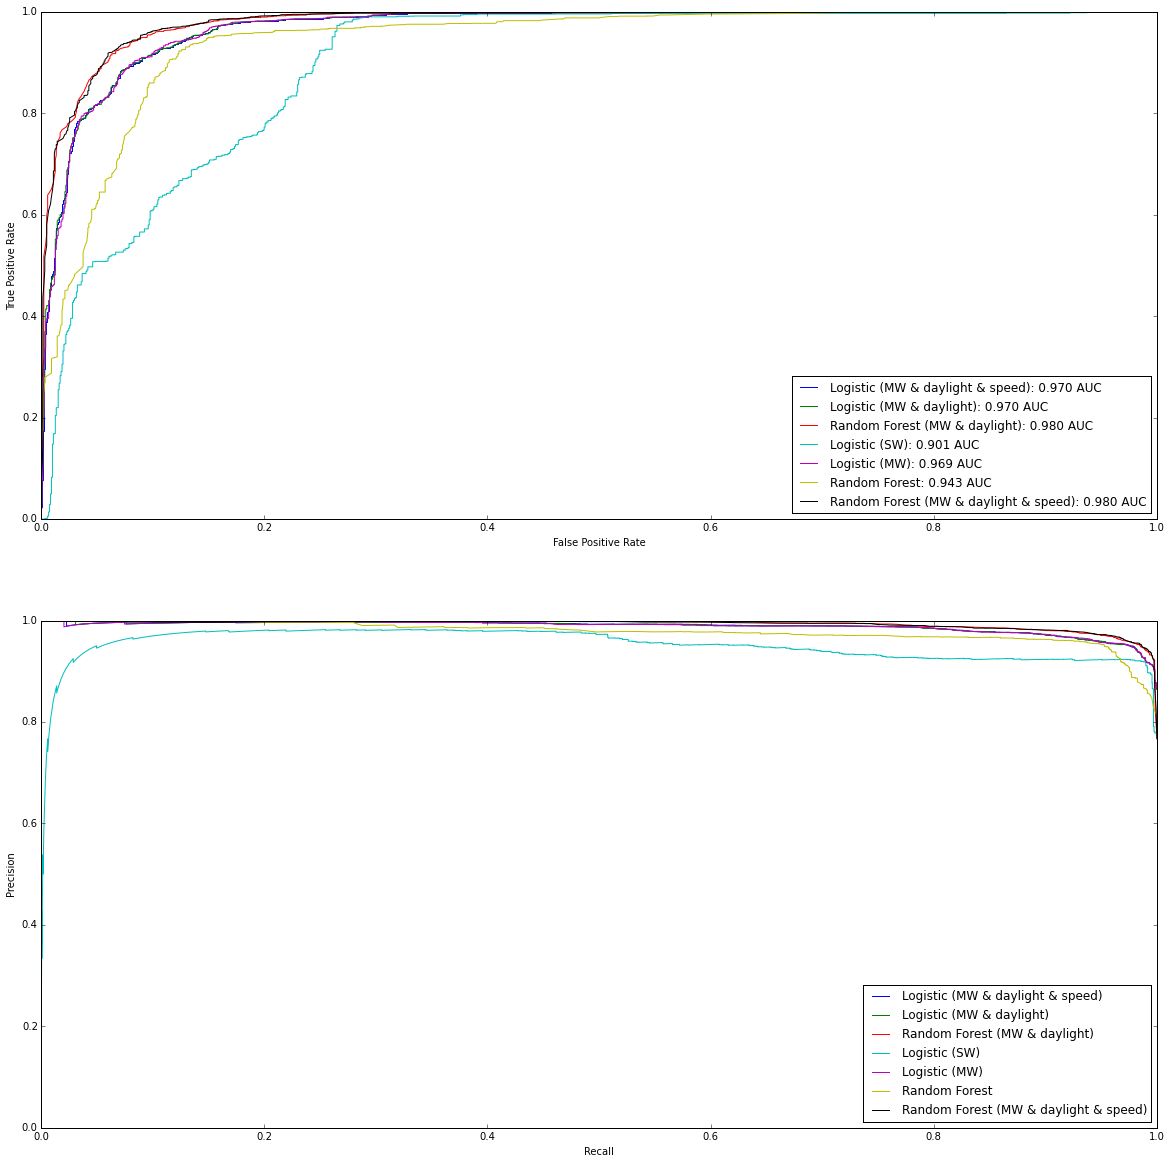

In [13]:
GEARS = {'ps': 'Purse seiners',
         'trawl': 'Trawlers',
         'longliner': 'Long liners'}

for gear, title in GEARS.iteritems():
    display(HTML("<h1>%s</h1>" % title))
        
    trained_models = [(name,
                       vessel_scoring.models.train_model(
                           name,
                           {"model": spec["model"],
                            "data": ['kristina_' + gear] + ['slow-transits'] * vessel_scoring.models.TRANSIT_WEIGHT},
                           data))
                      for (name, spec) in vessel_scoring.models.untrained_models.iteritems()
                      if spec.get("compare_models", False)]

    predictions = {}
    try:
        predictions["dal"] = vessel_scoring.evaluate_model.load_dal_predictions("../dal_{}_results.csv".format(gear))
    except IOError:
        pass
    testdata = data["kristina_" + gear]['test']
    vessel_scoring.evaluate_model.compare_models_at_cutoff(trained_models, testdata, predictions)
    vessel_scoring.evaluate_model.compare_models(trained_models, testdata)
    
    display(HTML("<hr/>"))

## Preparing Dalhouise Data 


In the `vessel-scoring` repo:

```
python scripts/make_ps_data_ready_for_dal.py
```

I disabled distshore in dal for the models that still have it using some hackery so that (a) it ran faster and (b) the comparisons were 'fair'.

Then in the `dal` repo:

```

# First, turned off distshore in the models that still have it using some hackery.

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_purse_seine.measures.from_npz.csv  ../vessel-scoring/dal_purse_seine_results.csv dalhouse/models/timeofday/

dal timothyhochberg$ Rscript dalhouse/models/trawler.R ../vessel-scoring/datasets/kristina_trawler.measures.from_npz.csv  ../vessel-scoring/dal_trawler_results.csv dalhouse/models/coastline/ data/training/trawl.csv 

Rscript dalhouse/models/purse-seiner.R ../vessel-scoring/datasets/kristina_longliner.measures.from_npz.csv  ../vessel-scoring/dal_longliner_results.csv dalhouse/models/timeofday/


```